In [1]:
# !wget https://raw.githubusercontent.com/DataTalksClub/machine-learning-zoomcamp/master/cohorts/2023/06-trees/homework.md

In [2]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [27]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
%%matplotlib inline

UsageError: Line magic function `%%matplotlib` not found.


In [4]:
df = pd.read_csv("housing.csv")

In [5]:
# keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'
df = df[
    (df.ocean_proximity == "<1H OCEAN")
    | (df.ocean_proximity == "INLAND")
]

df.ocean_proximity.unique()

array(['<1H OCEAN', 'INLAND'], dtype=object)

In [6]:
# we only want to use a subset of data. This is the same subset we used in homework #2.
base = [
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value',
]
df = df[base]
df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,37.64,-121.97,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,37.61,-121.99,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,37.57,-121.97,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,37.58,-121.96,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,37.58,-121.98,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0


In [7]:
df = df.fillna(0)

In [8]:
df.median_house_value = np.log1p(df.median_house_value)

In [9]:
random_seed = 1

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=random_seed)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=random_seed)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

#log1p is applied already before
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

del df_train["median_house_value"]
del df_val["median_house_value"]
del df_test["median_house_value"]

# Used uncommented for Q1
# del df_train["median_income"]
# del df_val["median_income"]
# del df_test["median_income"]

In [10]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient="records")
val_dicts = df_val.to_dict(orient="records")
test_dicts = df_test.to_dict(orient="records")

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

### Answer to Q1:
- ocean_proximity

In [11]:
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [12]:
print(dv.get_feature_names_out())
print(export_text(dtr, feature_names=list(dv.get_feature_names_out())))

# Which feature is used for splitting the data?


['households' 'housing_median_age' 'latitude' 'longitude' 'median_income'
 'population' 'total_bedrooms' 'total_rooms']
|--- median_income <= 3.66
|   |--- value: [11.72]
|--- median_income >  3.66
|   |--- value: [12.37]



## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

### Answer to Q2:
- 0.06

In [13]:
rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=1)
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=1, random_state=1)

In [14]:
y_pred = rfr.predict(X_val)
mean_squared_error(y_val, y_pred).round(3)

0.06

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?  
- **50**

In [15]:
results = []
for num in range(10, 210, 10):
    rfr = RandomForestRegressor(n_estimators=num, random_state=1, n_jobs=-1)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred).round(3)
    results.append((num, rmse))
    print(f"Finished calculating RMSE for {num=}")
df_results = pd.DataFrame(results, columns=["n_estimators", "rmse"])
df_results.head()


Finished calculating RMSE for num=10


Finished calculating RMSE for num=20
Finished calculating RMSE for num=30
Finished calculating RMSE for num=40
Finished calculating RMSE for num=50
Finished calculating RMSE for num=60
Finished calculating RMSE for num=70
Finished calculating RMSE for num=80
Finished calculating RMSE for num=90
Finished calculating RMSE for num=100
Finished calculating RMSE for num=110
Finished calculating RMSE for num=120
Finished calculating RMSE for num=130
Finished calculating RMSE for num=140
Finished calculating RMSE for num=150
Finished calculating RMSE for num=160
Finished calculating RMSE for num=170
Finished calculating RMSE for num=180
Finished calculating RMSE for num=190
Finished calculating RMSE for num=200


,n_estimators,rmse
0,10,0.060
1,20,0.057
2,30,0.057
3,40,0.056
4,50,0.056


(20.0, 70.0)

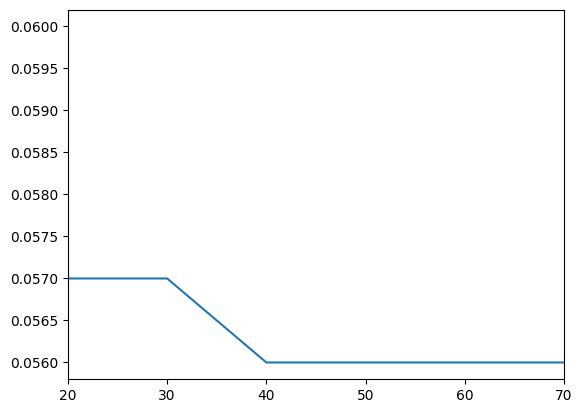

In [16]:
plt.plot(df_results.n_estimators, df_results.rmse)
plt.xlim(20, 70)

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`:

### Answer to Q4:
- **20** 

In [17]:
results_depth = []
for depth in [10, 15, 20, 25]:
    for num in range(10, 210, 10):
        rfr = RandomForestRegressor(n_estimators=num, random_state=1, n_jobs=-1, max_depth=depth)
        rfr.fit(X_train, y_train)
        y_pred = rfr.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred).round(3)
        results_depth.append((depth, num, rmse))
        print(f"Result for n_estimators={num}, {depth=}, {rmse}")

Result for n_estimators=10, depth=10, 0.063
Result for n_estimators=20, depth=10, 0.061
Result for n_estimators=30, depth=10, 0.06
Result for n_estimators=40, depth=10, 0.06
Result for n_estimators=50, depth=10, 0.06
Result for n_estimators=60, depth=10, 0.06
Result for n_estimators=70, depth=10, 0.06
Result for n_estimators=80, depth=10, 0.06
Result for n_estimators=90, depth=10, 0.06
Result for n_estimators=100, depth=10, 0.06
Result for n_estimators=110, depth=10, 0.06
Result for n_estimators=120, depth=10, 0.06
Result for n_estimators=130, depth=10, 0.06
Result for n_estimators=140, depth=10, 0.059
Result for n_estimators=150, depth=10, 0.059
Result for n_estimators=160, depth=10, 0.059
Result for n_estimators=170, depth=10, 0.059
Result for n_estimators=180, depth=10, 0.059
Result for n_estimators=190, depth=10, 0.059
Result for n_estimators=200, depth=10, 0.059
Result for n_estimators=10, depth=15, 0.06
Result for n_estimators=20, depth=15, 0.058
Result for n_estimators=30, depth

In [18]:
df_results_depth = pd.DataFrame(results_depth, columns=["depth", "n_estimators", "rmse"])
df_results_depth.head()

,depth,n_estimators,rmse
0,10,10,0.063
1,10,20,0.061
2,10,30,0.060
3,10,40,0.060
4,10,50,0.060


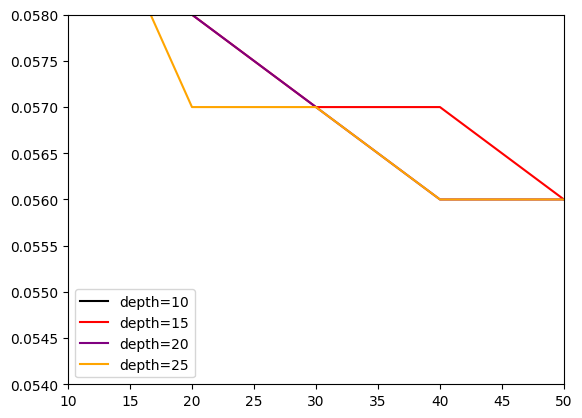

In [73]:
colors = ["black", "red", "purple", "orange"]
for depth, color in zip([10, 15, 20, 25], colors):
    df_subset = df_results_depth[df_results_depth.depth == depth]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f"depth={depth}", color=color)
    plt.ylim(0.054, 0.058)
    plt.xlim(10,50)
    plt.legend()

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

## Answer to Q5:
- median_income

In [20]:
n_est = 10
depth = 20
seed = 1
parallel = -1

rfq5 = RandomForestRegressor(n_estimators=n_est, max_depth=depth, random_state=seed, n_jobs=parallel)
rfq5.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [26]:
feature_importances = dict(zip(list(dv.get_feature_names_out()), rfq5.feature_importances_))
from operator import itemgetter
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
sorted_importances[0]

('median_income', 0.4878196602972747)

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

## Answer to Q6:
- * Both give equal value


In [56]:
%%capture lines

def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        print(line)
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    print(lines)
    return df_results


In [57]:
%%capture output
# Capture output to variable `output`

features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, "train"), (dval, "val")]
rounds = 100

def get_xgb_params(eta):
    return {
        'eta': eta, 
        'max_depth': 6,
        'min_child_weight': 1,
        
        'objective': 'reg:squarederror',

        'nthread': 8,
        
        'seed': 1,
        'verbosity': 1,
    }


model_eta_0_3 = xgb.train(
    get_xgb_params(0.3),
    dtrain,
    num_boost_round=rounds,
    verbose_eval=5,
    evals=watchlist,
)

[0]	train-rmse:0.52468	val-rmse:0.52081
[5]	train-rmse:0.37720	val-rmse:0.38068
[10]	train-rmse:0.30127	val-rmse:0.31431
[15]	train-rmse:0.26128	val-rmse:0.28156
[20]	train-rmse:0.23994	val-rmse:0.26646
[25]	train-rmse:0.22675	val-rmse:0.25847
[30]	train-rmse:0.21675	val-rmse:0.25311
[35]	train-rmse:0.20748	val-rmse:0.24829
[40]	train-rmse:0.20048	val-rmse:0.24434
[45]	train-rmse:0.19554	val-rmse:0.24228
[50]	train-rmse:0.19135	val-rmse:0.24067
[55]	train-rmse:0.18747	val-rmse:0.23903
[60]	train-rmse:0.18349	val-rmse:0.23742
[65]	train-rmse:0.18010	val-rmse:0.23631
[70]	train-rmse:0.17737	val-rmse:0.23543
[75]	train-rmse:0.17412	val-rmse:0.23430
[80]	train-rmse:0.17128	val-rmse:0.23340
[85]	train-rmse:0.16825	val-rmse:0.23219
[90]	train-rmse:0.16567	val-rmse:0.23152
[95]	train-rmse:0.16299	val-rmse:0.23098
[99]	train-rmse:0.16114	val-rmse:0.23075



'Best RMSE for eta=0.3 on validation dataset = 0.23075'

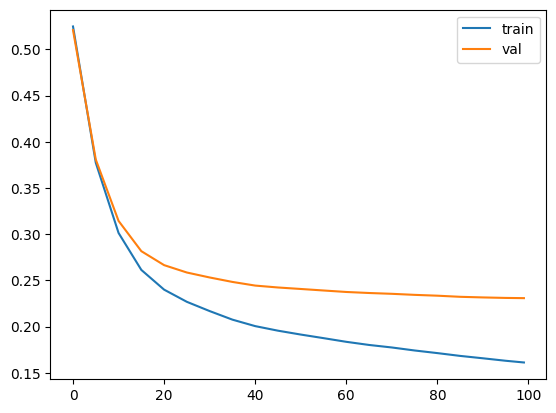

In [67]:
df_score_eta_0_3 = parse_xgb_output(output)
plt.plot(df_score_eta_0_3.num_iter, df_score_eta_0_3.train_rmse, label="train")
plt.plot(df_score_eta_0_3.num_iter, df_score_eta_0_3.val_rmse, label="val")
display(f"Best RMSE for eta=0.3 on validation dataset = {df_score_eta_0_3.val_rmse.min()}")
plt.legend()

In [62]:
%%capture output

model_eta_0_1 = xgb.train(
    get_xgb_params(0.1),
    dtrain,
    num_boost_round=rounds,
    verbose_eval=5,
    evals=watchlist,
)

[0]	train-rmse:0.52468	val-rmse:0.52081
[5]	train-rmse:0.37720	val-rmse:0.38068
[10]	train-rmse:0.30127	val-rmse:0.31431
[15]	train-rmse:0.26128	val-rmse:0.28156
[20]	train-rmse:0.23994	val-rmse:0.26646
[25]	train-rmse:0.22675	val-rmse:0.25847
[30]	train-rmse:0.21675	val-rmse:0.25311
[35]	train-rmse:0.20748	val-rmse:0.24829
[40]	train-rmse:0.20048	val-rmse:0.24434
[45]	train-rmse:0.19554	val-rmse:0.24228
[50]	train-rmse:0.19135	val-rmse:0.24067
[55]	train-rmse:0.18747	val-rmse:0.23903
[60]	train-rmse:0.18349	val-rmse:0.23742
[65]	train-rmse:0.18010	val-rmse:0.23631
[70]	train-rmse:0.17737	val-rmse:0.23543
[75]	train-rmse:0.17412	val-rmse:0.23430
[80]	train-rmse:0.17128	val-rmse:0.23340
[85]	train-rmse:0.16825	val-rmse:0.23219
[90]	train-rmse:0.16567	val-rmse:0.23152
[95]	train-rmse:0.16299	val-rmse:0.23098
[99]	train-rmse:0.16114	val-rmse:0.23075



'Best RMSE for eta=0.1 on validation dataset = 0.23075'

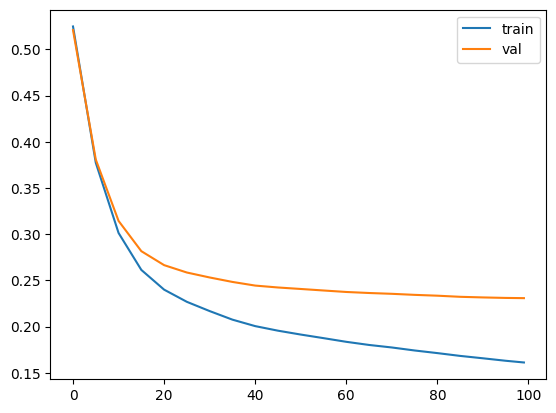

In [66]:
df_score_eta_0_1 = parse_xgb_output(output)
plt.plot(df_score_eta_0_1.num_iter, df_score_eta_0_1.train_rmse, label="train")
plt.plot(df_score_eta_0_1.num_iter, df_score_eta_0_1.val_rmse, label="val")
display(f"Best RMSE for eta=0.1 on validation dataset = {df_score_eta_0_1.val_rmse.min()}")
plt.legend()